# Лабораторная работа №4

**Задача детекции**


**1.1 Задача детекции**
Данная лабораторная работа включает в себя следующие темы, пройденные на курсе: использование keras; все, что связано для использования сверточных нейронных сетей; transfer learning.

**Задача:** предоставлен датасет, содержащий фотографии разных размеров (JPEG-формата) кошек и собак. Необходимо:

1. Прочитать датасет, преобразовать фотографии к необходимому формату.
2. Разделить датасет на тренировочные и валидационные данные.
3. Написать и обучить сверточный автоэнкодер на фотографиях.
4. Соединить кодировщик автоэнкодера с новой написанной нейросетью "головой" на вход которой будет поступать закодированное представление фотографий от кодировщика, а на выходе выводится ответ на задачу многоклассовой классификации — на фотографии кошка или собака.

**1.2 Некоторые советы и требования**
* Для последней, финальной сети, предсказывающей класс изображения, лучше использовать metrics = [’accuracy’] для того, чтобы было проще сравнивать полученные результаты разных саданчок.
* В качестве метода для чтения датасета можно использовать ImageDataGenerator.flow_from_directory (это поможет и для создания датасета для обучения автоэнкодера).
* Т.к. фотографии разных размеров, то предлагается привести их к, например, размеру 32x32 или 64x64. Слишком большой размер фотографий советуем не ставить, но эксперименты с любыми параметрами при создании датасета (например, аугментация) очень приветствуются.
* Архитектура автоэнкодера и "головы" финальной сети не регламентирована заданием, все на усмотрение выполняющего.
* Размерность пространства скрытых признаков, получаемых на выходе кодировщика, не должна превышать 10% от количества цветных пикселей фотографий после приведения к единому размеру.
* Использование таких слоев, как Dropout и BatchNormalization, может упростить обучение нейросети.
* Для отслеживания процесса обучения нейросети можно использовать callback из сторонней библиотеки livelossplot под названием PlotLossesKeras.

**Требования:**
* Код в jupyter-ноутбуке.
* Графики обучения нейросетей (loss, accuracy).
* Вывод изначальных фотографий + полученных после прохождения через автоэнкодер.
* Некоторое количество фотографий + реальные и предсказанные финальной нейросетью классы.

## Импорт библиотек и подготовка данных

### Импорт необходимых библиотек

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLossesKeras
import os

# включим ГПУ, иначе больно
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Используется GPU:", physical_devices)
else:
    print("Используется CPU.")

Используется GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Автоэнкодер

### Подготовка данных

In [ ]:
# Путь к папке с данными
data_dir = r'B:\data_science\work_place\datasets\cats-vs-dogs\train'

# Параметры
image_size = (64, 64)  # Размер изображения
batch_size = 32


# Создаем генераторы данных
datagen = ImageDataGenerator( # 80% для тренировки, 20% для тестирования + аугментация
    rescale=1./255, # масштабируем пиксели к диапазону [0,1]
    validation_split=0.2, # 80/20 выборка
    rotation_range=20, # поворот изображения
    width_shift_range=0.2, # сдвиг
    height_shift_range=0.2, # сдвиг
    shear_range=0.2, # диапазон сдвига
    zoom_range=0.2, # диапазон зума
    horizontal_flip=True, # крутим по горизонтали
    fill_mode='nearest' # Заполняет недостающие пиксели ближайшим
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input', # тип меток, которые ген. с изобр. тут - входные данные=метки, т.е 2 картинки
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    subset='validation',
    shuffle=True
)


Found 19997 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


**Визуализация некоторых изображений из датасета**

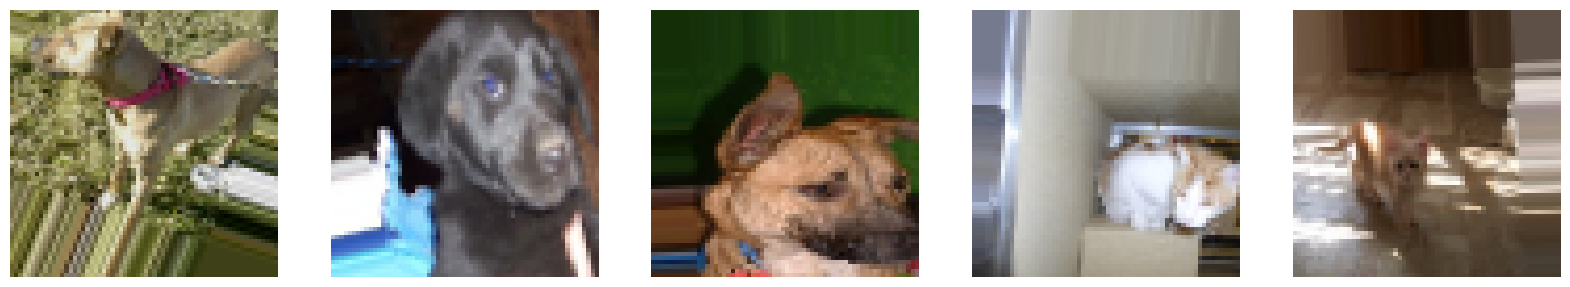

In [ ]:
# Посмотрим на картинки
images, _ = next(train_generator)

plt.figure(figsize=(20, 20))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.show()

Качество шакальное)

### Создание функции для автоэнкодера

In [ ]:
def create_autoencoder(input_shape):
    encoder_input = Input(shape=input_shape) #  входной слой с заданной формой
    # Свёрточный слой с 32 фильтрами размером 3x3; активация relu; padding=same (выход того же размера, что и вход.)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = BatchNormalization()(x) # Нормализует выходы
    x = MaxPooling2D((2, 2), padding='same')(x) # уменьшение размера в 2 раза
    x = Dropout(0.25)(x) # отключаем 25% нейронов

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    #  Количество фильтров увеличивается (32, 64, 128, 256),
    # чтобы модель могла извлекать более сложные признаки.

    encoder_output = Conv2D(512, (3, 3), activation='relu', padding='same')(x) # последний слой 512 фильтров
    encoder = Model(encoder_input, encoder_output, name="encoder") # определяем модель

    x = BatchNormalization()(encoder_output) # нормализация выходов декодера
    x = UpSampling2D((2, 2))(x) # увеличиваем размерность вдвое
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    #  Количество фильтров уменьшается (256, 128, 64, 32),
    # так как мы постепенно восстанавливаем изображение.

    decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) # загоняем сигмоидой пиксели в диапазон от 0 до 1
    decoder = Model(encoder_input, decoder_output, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder_input))
    autoencoder.compile(optimizer='adam', loss='mean_squared_error') # мин mse между входным и выходным изобр

    return autoencoder, encoder


input_shape = (image_size[0], image_size[1], 3) # 64x64, 3 (rgb)
autoencoder, encoder = create_autoencoder(input_shape)


In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         3142531   
                                                                 
Total params: 3,142,531
Trainable params: 3,139,587
Non-trainable params: 2,944
_________________________________________________________________


In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1849

### Обучение автоэнкодера


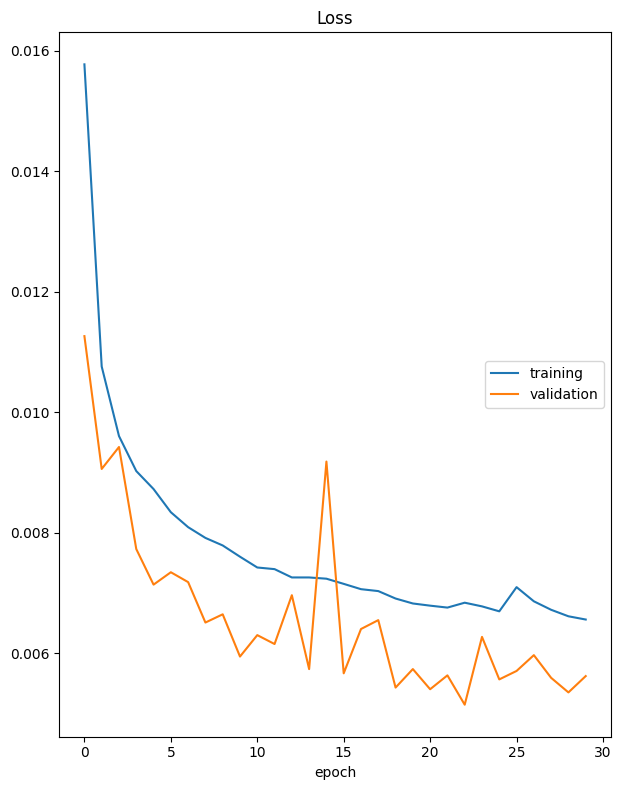

Loss
	training         	 (min:    0.007, max:    0.016, cur:    0.007)
	validation       	 (min:    0.005, max:    0.011, cur:    0.006)

Epoch 30: val_loss did not improve from 0.00515
625/625 [==============================] - 56s 90ms/step - loss: 0.0066 - val_loss: 0.0056


In [ ]:
# Обучение автоэнкодера
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True) # следим за валидационной потерей
plot_losses = PlotLossesKeras()
checkpoint = ModelCheckpoint("best_autoencoder.h5", monitor='val_loss', save_best_only=True, verbose=1)

autoencoder.fit(
    train_generator,
    steps_per_epoch=len(train_generator), # 625 - определяют сколько батчей будет обработано за эпоху (кол-во изображений/размер батчка)
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator), # 157
    callbacks=[early_stopping, plot_losses, checkpoint]
)


1/1 [==============================] - 0s 19ms/step


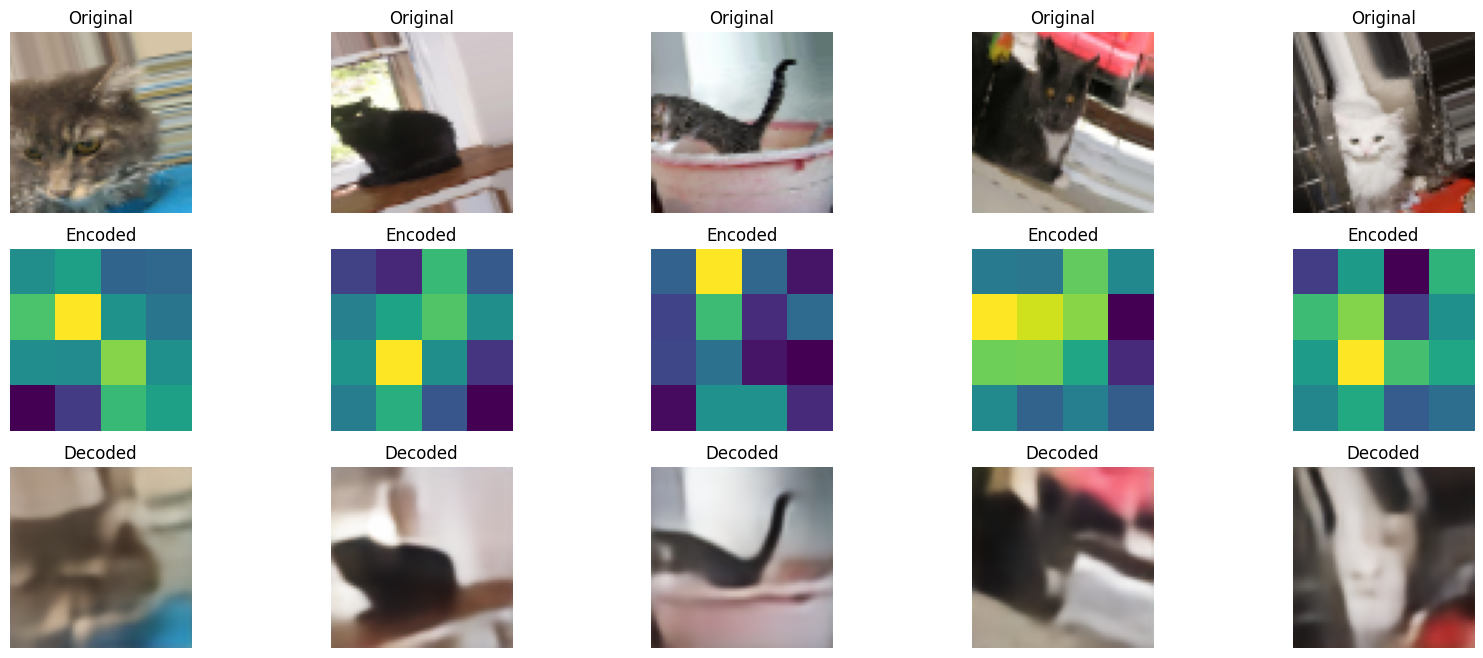

In [ ]:
# Функция для визуализации картинок
def plot_autoencoder_results(original_images, encoded_images, decoded_images, num_images=5):
    plt.figure(figsize=(20, 8))
    for i in range(num_images):
        # На вход
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.axis('off')

        # Закодированные изображения
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        encoded_img = encoded_images[i]
        encoded_img = np.mean(encoded_img, axis=-1)  # усредняем по каналу для отображения
        plt.imshow(encoded_img, cmap='viridis')
        plt.axis('off')

        # Восстановленные котики собаки
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(decoded_images[i])
        plt.axis('off')
    plt.show()

encoded_images = encoder.predict(images[0][:5])
decoded_images = autoencoder.predict(images[0][:5])

plot_autoencoder_results(images[0][:5], encoded_images, decoded_images)


## Нейронка для классификации

### Подготовка данных

In [ ]:
# Поделим на наборы данных с метками
train_generator_with_labels = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator_with_labels = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 19997 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


### Создание нейронной сетки для классификации

In [ ]:
early_stopping_full = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True) # val_loss - cследим за валидационной потерей
checkpoint_full = ModelCheckpoint("best_classifier.h5", monitor='val_loss', save_best_only=True, verbose=1)
plot_losses_full = PlotLossesKeras()


# Заморозка слоев кодировщика
#for layer in encoder.layers:
#   layer.trainable = False


# Функция для построения полной модели для классификации уже

def create_full_model(encoder, input_shape):
    encoded_input = encoder.output # голова в виде энкодера
    x = Flatten()(encoded_input) # преобразование многомерного тензор в одномерный

    # 1 слой
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # 2 слой
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # 3 слой
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # выход
    x = Dense(1, activation='sigmoid')(x)

    classifier = Model(encoder.input, x, name="classifier")
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier


classifier = create_full_model(encoder, input_shape)
classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

### Обучение классификатора

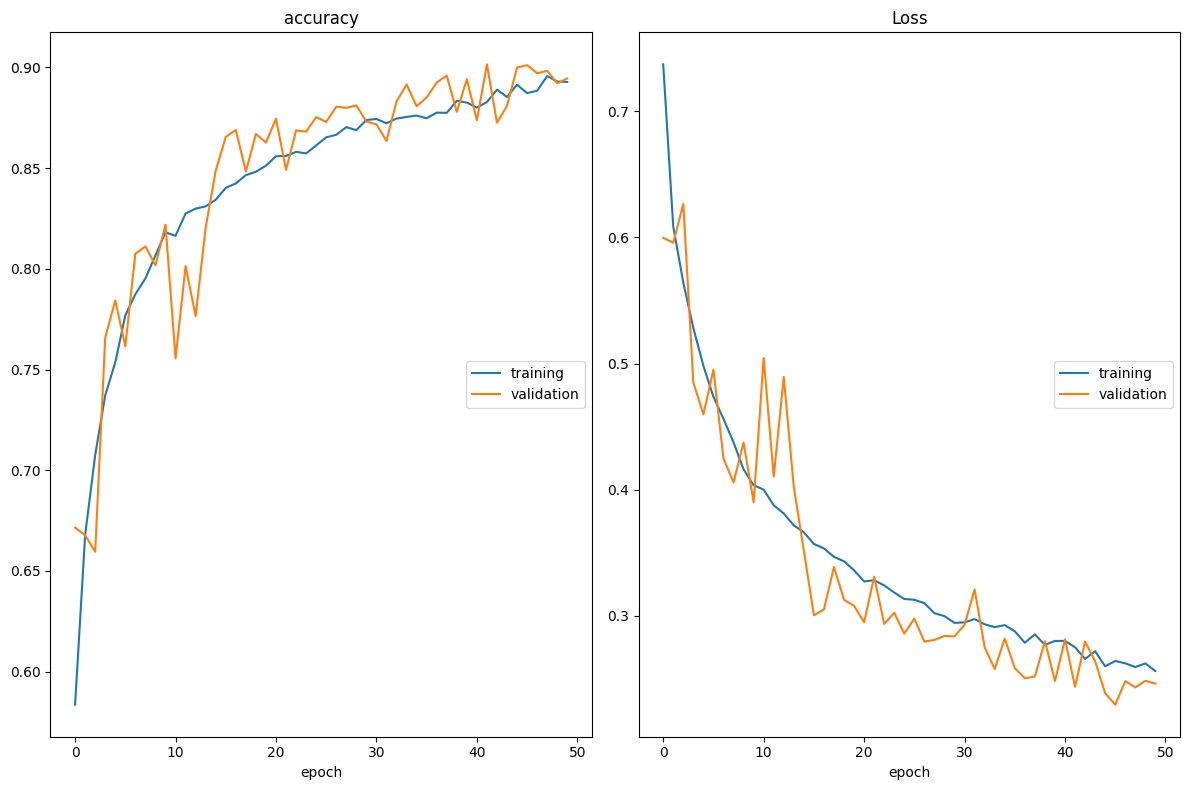

accuracy
	training         	 (min:    0.584, max:    0.896, cur:    0.893)
	validation       	 (min:    0.659, max:    0.902, cur:    0.895)
Loss
	training         	 (min:    0.256, max:    0.737, cur:    0.256)
	validation       	 (min:    0.230, max:    0.626, cur:    0.246)

Epoch 50: val_loss did not improve from 0.22972
625/625 [==============================] - 53s 85ms/step - loss: 0.2564 - accuracy: 0.8928 - val_loss: 0.2464 - val_accuracy: 0.8946


In [ ]:
classifier.fit(
    train_generator_with_labels,
    steps_per_epoch=len(train_generator_with_labels),
    epochs=50,
    validation_data=validation_generator_with_labels,
    validation_steps=len(validation_generator_with_labels),
    callbacks=[early_stopping_full, plot_losses_full, checkpoint_full]
)


1/1 [==============================] - 0s 18ms/step


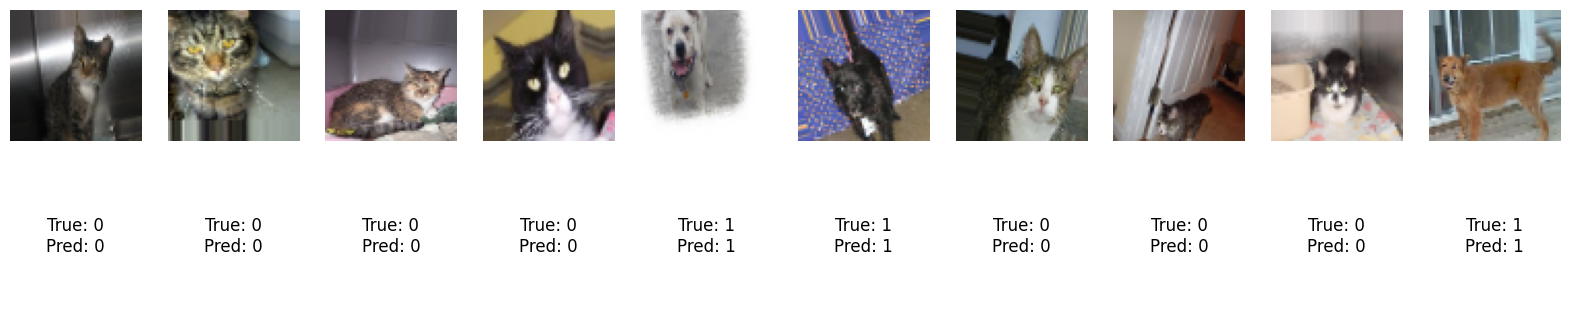

In [ ]:
# Посмотрим что мы напредсказывали
def plot_predictions(data, model):
    x, y = next(data)
    y_pred = (model.predict(x) > 0.5).astype(int)
    plt.figure(figsize=(20, 8))

    for i in range(10):

        ax = plt.subplot(4, 10, i + 1)
        plt.imshow(x[i])
        plt.axis('off')

        ax = plt.subplot(4, 10, i + 11)
        plt.text(0.5, 0.5, f'True: {int(y[i])}\nPred: {y_pred[i][0]}', fontsize=12, ha='center', va='center')
        plt.axis('off')

    plt.show()

plot_predictions(validation_generator_with_labels, classifier)